In [586]:
# Notes for user:
# This notebook will use the dataset COVID-19 and forex to predict the forex spot price of a currency pair.
# What to ask user before using this application:
# What currency pair are you interested in? USD/GBP (This layout means that the base currency is USD)
# The currency the user wants to look at is how much the USD is worth to the GBP.
# Therefore, we look at the death rates in the US and the UK.


# Use some functions from tensorflow_docs
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-v2tw76c2
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-v2tw76c2
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0a610a0dfdbc3aa8b6ede00aa698b20ede1bfbc6a_-cp36-none-any.whl size=124951 sha256=2bfa479372b5e9734da4021e95ad9eddc1aaa2127328f2d79daa9dd134f9f8e8
  Stored in directory: /tmp/pip-ephem-wheel-cache-vf508ri8/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs


In [587]:
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [588]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print(tf.__version__)

2.2.0


In [589]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [590]:
# Importing covid_dataset using pandas. Droping null values.
covid_dataset_data= pd.read_csv('covid.csv', na_values = "?", comment='\t', skipinitialspace=True)
covid_dataset = covid_dataset_data.copy()
# covid_dataset = covid_dataset.dropna()
covid_dataset.head()

,iso_code,continent,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,tests_units,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cvd_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
0,AFG,Asia,Afghanistan,2019-12-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
1,AFG,Asia,Afghanistan,2020-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
2,AFG,Asia,Afghanistan,2020-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
3,AFG,Asia,Afghanistan,2020-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
4,AFG,Asia,Afghanistan,2020-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83


In [591]:
# Trying to isolate location/country based on currency in question
# We are looking at pound and sterling therefore need to isolate 'United Kingdom' & 'United States' in location column
# Problem: Informaiton prints up until 'Trinidad and Tobago' for some reason – can print 'Togo'. Therefore cannot print United Kingdom or United States
us_death_rates = covid_dataset.loc[covid_dataset.location=='United States', ['location', 'date', 'total_deaths', 'total_cases', 'cvd_death_rate']]
us_death_rates.head()

,location,date,total_deaths,total_cases,cvd_death_rate
26490,United States,2019-12-31,0.0,0.0,151.089
26491,United States,2020-01-01,0.0,0.0,151.089
26492,United States,2020-01-02,0.0,0.0,151.089
26493,United States,2020-01-03,0.0,0.0,151.089
26494,United States,2020-01-04,0.0,0.0,151.089


In [592]:
# us_death_rates = covid_dataset.loc[covid_dataset.location=='Zimbabwe', ['location', 'date', 'total_deaths','total_cases','cvd_death_rate']]
# us_death_rates.head()

In [593]:
us_death_rates.shape

(187, 5)

In [594]:
# Import forex
forex_dataset_data= pd.read_csv('GBP_USD.csv', na_values = "?", comment='\t', skipinitialspace=True)
forex_dataset = forex_dataset_data.copy()
# forex_dataset = forex_dataset_data.dropna()
# Filter dataset
forex_dataset.pop('Open')
forex_dataset.pop('High')
forex_dataset.pop('Low')
forex_dataset.pop('Change %')


0       0.12%
1      -0.05%
2       0.59%
3       0.83%
4      -0.30%
        ...  
150    -0.15%
151     0.40%
152     0.85%
153     0.44%
154     0.02%
Name: Change %, Length: 155, dtype: object

In [595]:
forex_dataset.tail()

,Date,Price
150,"Dec 06, 2019",1.3137
151,"Dec 05, 2019",1.3157
152,"Dec 04, 2019",1.3104
153,"Dec 03, 2019",1.2994
154,"Dec 02, 2019",1.2937


In [596]:
# Isolate covid_date
import time 
us_date = us_death_rates['date']
new_us_dates = [time.strptime(x.replace("-"," "), '%Y %m %d')for x in us_date]
us_death_rates['date'] = new_us_dates
us_death_rates.head()


,location,date,total_deaths,total_cases,cvd_death_rate
26490,United States,"(2019, 12, 31, 0, 0, 0, 1, 365, -1)",0.0,0.0,151.089
26491,United States,"(2020, 1, 1, 0, 0, 0, 2, 1, -1)",0.0,0.0,151.089
26492,United States,"(2020, 1, 2, 0, 0, 0, 3, 2, -1)",0.0,0.0,151.089
26493,United States,"(2020, 1, 3, 0, 0, 0, 4, 3, -1)",0.0,0.0,151.089
26494,United States,"(2020, 1, 4, 0, 0, 0, 5, 4, -1)",0.0,0.0,151.089


In [597]:
# Isolate forex_date
import time 
forex_date = forex_dataset['Date']
new_forex_dates = [time.strptime(x.replace(',', ""), '%b %d %Y')for x in forex_date]
forex_dataset['Date'] = new_forex_dates
forex_dataset.tail()

,Date,Price
150,"(2019, 12, 6, 0, 0, 0, 4, 340, -1)",1.3137
151,"(2019, 12, 5, 0, 0, 0, 3, 339, -1)",1.3157
152,"(2019, 12, 4, 0, 0, 0, 2, 338, -1)",1.3104
153,"(2019, 12, 3, 0, 0, 0, 1, 337, -1)",1.2994
154,"(2019, 12, 2, 0, 0, 0, 0, 336, -1)",1.2937


In [598]:
# Merging dates from two tables
dataset = pd.merge(left=forex_dataset, left_on='Date',
         right=us_death_rates, right_on='date')
dataset.tail()


,Date,Price,location,date,total_deaths,total_cases,cvd_death_rate
129,"(2020, 1, 6, 0, 0, 0, 0, 6, -1)",1.3169,United States,"(2020, 1, 6, 0, 0, 0, 0, 6, -1)",0.0,0.0,151.089
130,"(2020, 1, 3, 0, 0, 0, 4, 3, -1)",1.3088,United States,"(2020, 1, 3, 0, 0, 0, 4, 3, -1)",0.0,0.0,151.089
131,"(2020, 1, 2, 0, 0, 0, 3, 2, -1)",1.3146,United States,"(2020, 1, 2, 0, 0, 0, 3, 2, -1)",0.0,0.0,151.089
132,"(2020, 1, 1, 0, 0, 0, 2, 1, -1)",1.3255,United States,"(2020, 1, 1, 0, 0, 0, 2, 1, -1)",0.0,0.0,151.089
133,"(2019, 12, 31, 0, 0, 0, 1, 365, -1)",1.3261,United States,"(2019, 12, 31, 0, 0, 0, 1, 365, -1)",0.0,0.0,151.089


In [599]:
# We pop the 'date' from the covid_dataset because this column starts later than the forex column
# We want to see the forex price before covid happened
dataset.pop('date')

0        (2020, 7, 3, 0, 0, 0, 4, 185, -1)
1        (2020, 7, 2, 0, 0, 0, 3, 184, -1)
2        (2020, 7, 1, 0, 0, 0, 2, 183, -1)
3       (2020, 6, 30, 0, 0, 0, 1, 182, -1)
4       (2020, 6, 29, 0, 0, 0, 0, 181, -1)
                      ...                 
129        (2020, 1, 6, 0, 0, 0, 0, 6, -1)
130        (2020, 1, 3, 0, 0, 0, 4, 3, -1)
131        (2020, 1, 2, 0, 0, 0, 3, 2, -1)
132        (2020, 1, 1, 0, 0, 0, 2, 1, -1)
133    (2019, 12, 31, 0, 0, 0, 1, 365, -1)
Name: date, Length: 134, dtype: object

In [600]:
# Problem: This still starts at 2019,12,13 when we want 2019,12,02
# However this does not affect our data graph for some reason - scroll down
dataset.tail()

,Date,Price,location,total_deaths,total_cases,cvd_death_rate
129,"(2020, 1, 6, 0, 0, 0, 0, 6, -1)",1.3169,United States,0.0,0.0,151.089
130,"(2020, 1, 3, 0, 0, 0, 4, 3, -1)",1.3088,United States,0.0,0.0,151.089
131,"(2020, 1, 2, 0, 0, 0, 3, 2, -1)",1.3146,United States,0.0,0.0,151.089
132,"(2020, 1, 1, 0, 0, 0, 2, 1, -1)",1.3255,United States,0.0,0.0,151.089
133,"(2019, 12, 31, 0, 0, 0, 1, 365, -1)",1.3261,United States,0.0,0.0,151.089


In [601]:
# Object means string
dataset.dtypes

Date               object
Price             float64
location           object
total_deaths      float64
total_cases       float64
cvd_death_rate    float64
dtype: object

In [602]:
# View what date looks like
date = dataset['Date']
date.head()

0     (2020, 7, 3, 0, 0, 0, 4, 185, -1)
1     (2020, 7, 2, 0, 0, 0, 3, 184, -1)
2     (2020, 7, 1, 0, 0, 0, 2, 183, -1)
3    (2020, 6, 30, 0, 0, 0, 1, 182, -1)
4    (2020, 6, 29, 0, 0, 0, 0, 181, -1)
Name: Date, dtype: object

In [603]:
# Splitting timestamp and isolating the date
dateFormatting = pd.DataFrame({'my_timestamp': pd.date_range('2019-12-02 15:00', periods=len(date))})
dateFormatting['new_date'] = [d.date() for d in dateFormatting['my_timestamp']]
dateFormatting['new_time'] = [d.time() for d in dateFormatting['my_timestamp']]
print(dateFormatting)


           my_timestamp    new_date  new_time
0   2019-12-02 15:00:00  2019-12-02  15:00:00
1   2019-12-03 15:00:00  2019-12-03  15:00:00
2   2019-12-04 15:00:00  2019-12-04  15:00:00
3   2019-12-05 15:00:00  2019-12-05  15:00:00
4   2019-12-06 15:00:00  2019-12-06  15:00:00
..                  ...         ...       ...
129 2020-04-09 15:00:00  2020-04-09  15:00:00
130 2020-04-10 15:00:00  2020-04-10  15:00:00
131 2020-04-11 15:00:00  2020-04-11  15:00:00
132 2020-04-12 15:00:00  2020-04-12  15:00:00
133 2020-04-13 15:00:00  2020-04-13  15:00:00

[134 rows x 3 columns]


In [604]:
# Convert date to list so that we can use the dates to plot on graph
my_xticks = dateFormatting['new_date'].tolist()
print(my_xticks)

[datetime.date(2019, 12, 2), datetime.date(2019, 12, 3), datetime.date(2019, 12, 4), datetime.date(2019, 12, 5), datetime.date(2019, 12, 6), datetime.date(2019, 12, 7), datetime.date(2019, 12, 8), datetime.date(2019, 12, 9), datetime.date(2019, 12, 10), datetime.date(2019, 12, 11), datetime.date(2019, 12, 12), datetime.date(2019, 12, 13), datetime.date(2019, 12, 14), datetime.date(2019, 12, 15), datetime.date(2019, 12, 16), datetime.date(2019, 12, 17), datetime.date(2019, 12, 18), datetime.date(2019, 12, 19), datetime.date(2019, 12, 20), datetime.date(2019, 12, 21), datetime.date(2019, 12, 22), datetime.date(2019, 12, 23), datetime.date(2019, 12, 24), datetime.date(2019, 12, 25), datetime.date(2019, 12, 26), datetime.date(2019, 12, 27), datetime.date(2019, 12, 28), datetime.date(2019, 12, 29), datetime.date(2019, 12, 30), datetime.date(2019, 12, 31), datetime.date(2020, 1, 1), datetime.date(2020, 1, 2), datetime.date(2020, 1, 3), datetime.date(2020, 1, 4), datetime.date(2020, 1, 5), da

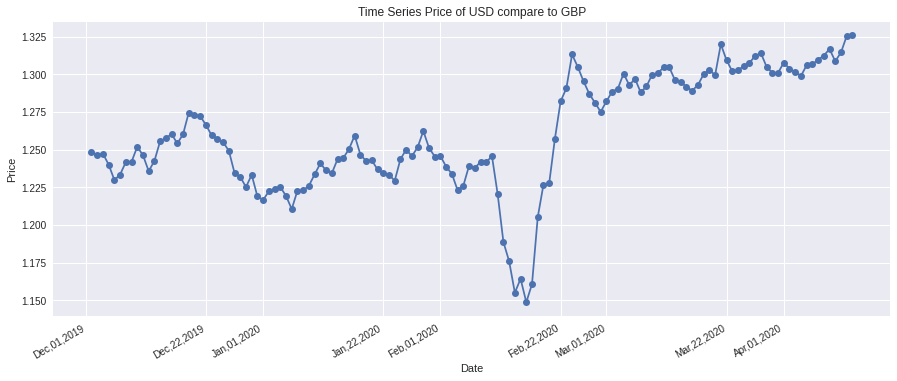

In [605]:
# Plotted prices and dates
# Notice how the dates start and end

from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from matplotlib import dates as mpl_dates
plt.style.use('seaborn')
from matplotlib import rcParams
rcParams['figure.figsize'] = 15,6

dates = np.array(dateFormatting['new_date'])
price = np.array(dataset['Price'])
plt.plot_date(dates,price, linestyle ='solid')
plt.gcf().autofmt_xdate()
date_format = mpl_dates.DateFormatter('%b,%d,%Y')
plt.title('Time Series Price of USD compare to GBP')
plt.xlabel('Date')
plt.ylabel('Price')
plt.gca().xaxis.set_major_formatter(date_format)

In [606]:
# print(price)
test = np.array(dataset['total_deaths'])
# print(test)
price.shape
# test.shape

test = np.array(dataset['total_deaths'])
list = np.array(test)
reversed_arr = list[::-1]
reversed_arr.shape
price.shape

(134,)

In [607]:
# Adds the accumulative deaths every day of a country
# Problem – This needs to be sorted from the end since the way out data is set up - can this be made more efficient?
total_us_deaths = dataset['total_deaths']
list = np.array(total_us_deaths)
reversed_arr = list[::-1]
newDay = 0
day = []
for currentday in reversed_arr:
   newDay = currentday + newDay
   day.append(newDay)


Text(0, 0.5, 'Total Deaths')

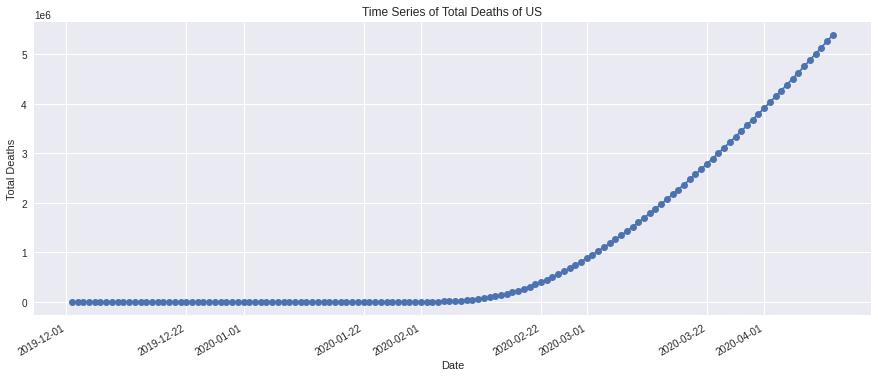

In [608]:
# Plots the accumulative daily death rates of a country
dates = np.array(dateFormatting['new_date'])
us_deaths = np.array(day)
plt.plot_date(dates,us_deaths, linestyle ='solid')
plt.gcf().autofmt_xdate()
date_format = mpl_dates.DateFormatter('%b,%d,%Y')
plt.title('Time Series of Total Deaths of US')
plt.xlabel('Date')
plt.ylabel('Total Deaths')


In [609]:
test.shape

(134,)

In [610]:
price.shape

(134,)

In [611]:
price_frame = pd.DataFrame(np.concatenate([price]), columns= ["Price"])
death_frame = pd.DataFrame(np.concatenate([day]), columns= ["Total_Deaths_US"])
print(price_frame)
print(death_frame)

      Price
0    1.2482
1    1.2467
2    1.2474
3    1.2401
4    1.2299
..      ...
129  1.3169
130  1.3088
131  1.3146
132  1.3255
133  1.3261

[134 rows x 1 columns]
     Total_Deaths_US
0                0.0
1                0.0
2                0.0
3                0.0
4                0.0
..               ...
129        4881974.0
130        5008114.0
131        5135524.0
132        5263586.0
133        5392326.0

[134 rows x 1 columns]


In [612]:
# Working Normalised method!!
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
normalisation_us_deaths = scaler.fit_transform(death_frame).reshape(-1,1)
normalisation_price = scaler.fit_transform(price_frame).reshape(-1,1)
print(normalisation_us_deaths)

[[0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [3.70897457e-07]
 [1.48358983e-06]
 [3.15262838e-06]
 [5.19256440e-06]
 [7.41794914e-06]
 [1.13123724e-05]
 [1.61340394e-05]
 [2.13266038e-05]
 [2.68900656e-05]
 [3.43080148e-05]
 [4.71039770e-05]
 [6.286711

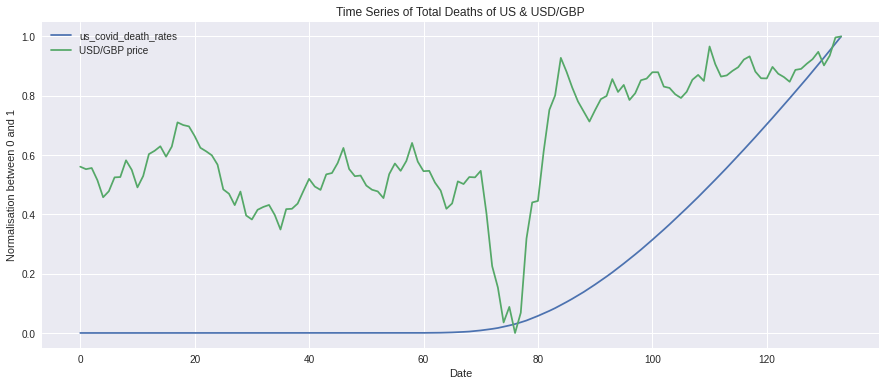

In [613]:
# Inspect the data
# Look at join distributions of afew pairs of collumns from the training set
# Need to revise what this graph does
import matplotlib.pyplot as plt
plt.title('Time Series of Total Deaths of US & USD/GBP')
plt.plot(normalisation_us_deaths,label="us_covid_death_rates")
plt.plot(normalisation_price, label="USD/GBP price")
plt.ylabel('Normalisation between 0 and 1')
plt.xlabel('Date')
plt.legend() 
plt.show()

In [614]:
# Test & Train split => Preprocessing the data 
# Splitting dataset into train and test split
# 65% of the total length of my datadrame
# 35% test size
training_size = int(len(normalisation_us_deaths)*0.65)
test_size = len(normalisation_us_deaths)-training_size
train_data, test_data = normalisation_us_deaths[0:training_size,:], normalisation_us_deaths[training_size:len(normalisation_us_deaths),:1]
print(normalisation_us_deaths)


[[0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [3.70897457e-07]
 [1.48358983e-06]
 [3.15262838e-06]
 [5.19256440e-06]
 [7.41794914e-06]
 [1.13123724e-05]
 [1.61340394e-05]
 [2.13266038e-05]
 [2.68900656e-05]
 [3.43080148e-05]
 [4.71039770e-05]
 [6.286711

In [615]:
training_size, test_size

(87, 47)

In [616]:
len(train_data), len(test_data)

(87, 47)

In [617]:
train_data

array([[0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],


In [618]:
# Convert an array of values into a dataset matrix
# time_step = how many previous days you have to consider before making a prediction
# all data, need to split: [120,130,125,140,134,150,160,190,154,160,170]
# timesteps = 3
# train data = [120,130,125,140,134,150]
# test data = [160,190,154,160,170]
# X_train = f1,f2,f3
# Y_train = o/p
# f1  f2  f3  o/p
# 120 130 125 140
# 130 125 140 134
# X_test = f1,f2,f3
# Y_test = o/p
# f1  f2  f3  o/p
# 160 190 154 160
# 190 154 160 170
def create_dataset(dataset, time_step=1):
  dataX, dataY = [],[]
  # then we subtract e.g. timestep=3 : lendataset -3-3 so you are shifting
  for i in range(len(dataset)-time_step-1):
    a = dataset[i:(i+time_step),0]  # i=0, 0,1,2,3
    dataX.append(a)
    dataY.append(dataset[i + time_step, 0])
  return np.array(dataX), np.array(dataY)

In [619]:
# time_step is the number of days at the end
# features: it takes in both the train and test and the number of days from the end
time_step = 7
X_train, Y_train = create_dataset(train_data, time_step)
X_test, Y_test = create_dataset(test_data, time_step)

In [620]:
# print(X_train)

In [621]:
# This should be ordered in respect to date – not cross validation or random seed
# We are going to divide our data based on date because the next data is always dependent on the previous data
# 7 features at a time f1,f2,f3,f4,f5,f6,f7
print(X_train.shape), print(Y_train.shape)


(79, 7)
(79,)


(None, None)

In [622]:
print(X_test.shape), print(Y_test.shape)
# Finished preprocessing the data

(39, 7)
(39,)


(None, None)

In [623]:
# Need to convert this to a 3D 
# reshape input to be [samples, time_steps, features] which is required for lstm
# therefore we add ,1 to convert to 3d
# 7,1 will be the input to our LSTM
# xtrain.shape = 79, 7, 1
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1],1)

In [624]:
# Create the stacked LSTM model
# One LSTM after the other
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

model = Sequential()

model.add(LSTM(3,return_sequences=True,input_shape=(7,1)))
model.add(LSTM(3, return_sequences=True))
model.add(LSTM(3))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer='adam')

In [625]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_33 (LSTM)               (None, 7, 3)              60        
_________________________________________________________________
lstm_34 (LSTM)               (None, 7, 3)              84        
_________________________________________________________________
lstm_35 (LSTM)               (None, 3)                 84        
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 4         
Total params: 232
Trainable params: 232
Non-trainable params: 0
_________________________________________________________________


In [626]:
# Main aim should be to minimise the loss
model.fit(X_train, Y_train, validation_data=(X_test,Y_test), epochs=100,batch_size=64,verbose=1)

Epoch 1/100
2/2 [==============================] - 1s 602ms/step - loss: 5.6657e-04 - val_loss: 0.3362
Epoch 2/100
2/2 [==============================] - 0s 26ms/step - loss: 5.0118e-04 - val_loss: 0.3299
Epoch 3/100
2/2 [==============================] - 0s 25ms/step - loss: 4.9056e-04 - val_loss: 0.3258
Epoch 4/100
2/2 [==============================] - 0s 26ms/step - loss: 5.0130e-04 - val_loss: 0.3241
Epoch 5/100
2/2 [==============================] - 0s 26ms/step - loss: 5.0596e-04 - val_loss: 0.3241
Epoch 6/100
2/2 [==============================] - 0s 25ms/step - loss: 4.9322e-04 - val_loss: 0.3259
Epoch 7/100
2/2 [==============================] - 0s 26ms/step - loss: 4.9084e-04 - val_loss: 0.3274
Epoch 8/100
2/2 [==============================] - 0s 27ms/step - loss: 4.8347e-04 - val_loss: 0.3273
Epoch 9/100
2/2 [==============================] - 0s 33ms/step - loss: 4.8351e-04 - val_loss: 0.3267
Epoch 10/100
2/2 [==============================] - 0s 26ms/step - loss: 4.8407e-

In [627]:
# Prediction and check performance metric
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)


In [628]:
# Transform back to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [629]:
# Calculate the RMSE performance metrics
# Output for the train dataset
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(Y_train, train_predict))

1.1407341551423842

In [630]:
# Similarly for the test Data RMSE
math.sqrt(mean_squared_error(Y_test, test_predict))

0.714486580303917

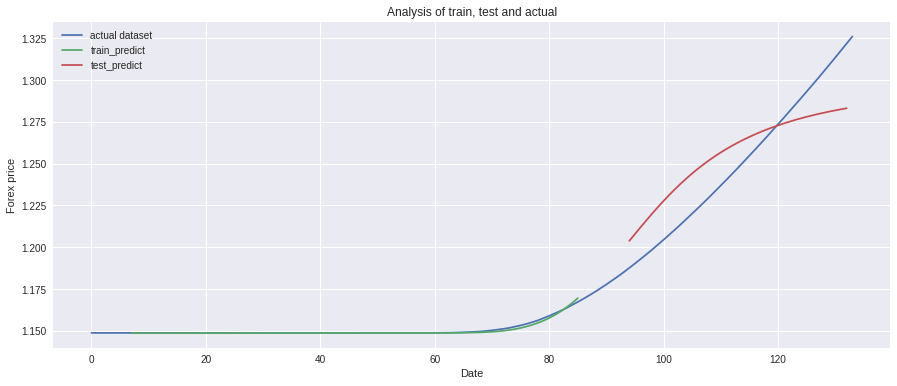

In [631]:
# Plotting
# Shift train predictions for plotting
look_back = 7
trainPredictPlot = np.empty_like(normalisation_us_deaths)
trainPredictPlot[:,:]= np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# Shift test predictions for plotting
testPredictPlot = np.empty_like(normalisation_us_deaths)
testPredictPlot[:,:]= np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1: len(normalisation_us_deaths)-1, :] = test_predict
# Plot baseline and predictions
plt.title('Analysis of train, test and actual')
plt.plot(scaler.inverse_transform(normalisation_us_deaths), label="actual dataset")
plt.plot(trainPredictPlot, label="train_predict")
# as you can see th test data and train is divided because we want to test after a specific day
plt.plot(testPredictPlot, label="test_predict")
plt.ylabel('Forex price')
plt.xlabel('Date')
plt.legend()
plt.show()
# We have predicted the future output
# green is test_predict data
# red is train_predict data


In [632]:
# Predict the future 30 days
# imagine in test data the last output was 23/may and you want to predict the 24/may
len(test_data) 

47

In [633]:
X_input=test_data[40:].reshape(1,-1)
X_input.shape

(1, 7)

In [634]:
# temp_input=list(X_input)
# temp_input=temp_input[0].tolist()
# print(temp_input)
# print(X_input)
# should be: 
# [0.85895289 0.88202568 0.90535587 0.92874837 0.9523764  0.97612533
#  1.        ]
# error: 'numpy.ndarray' object is not callable
# for not:
temp_input = [0.85895289,0.88202568,0.90535587,0.92874837,0.9523764,0.97612533,1.]
print(temp_input)

[0.85895289, 0.88202568, 0.90535587, 0.92874837, 0.9523764, 0.97612533, 1.0]


In [635]:
temp_input

[0.85895289, 0.88202568, 0.90535587, 0.92874837, 0.9523764, 0.97612533, 1.0]

In [636]:
# Demonstrate prediction for the next 4 days
from numpy import array
lst_output=[]
n_steps=7
i=0
while(i<4):
  if(len(temp_input)>7):
    #print(temp_input)
    # if length is more than 7, 1: shifting one position
    X_input=np.array(temp_input[1:])
    # --> print("{} day input {}".format(i,X_input))
    X_input=X_input.reshape(1,-1)
    X_input=X_input.reshape((1,n_steps,1))
    # print(x_input)
    Y_hat = model.predict(X_input, verbose=0)
    # --> print("{} day input {}".format(i,Y_hat))
    temp_input.extend(Y_hat[0].tolist())
    temp_input=temp_input[1:]
    #print(temp_input)
    lst_output.extend(Y_hat.tolist())
    i=i+1
  else:
    X_input = X_input.reshape((1,n_steps,1))
    Y_hat = model.predict(X_input, verbose=0)
    # print(Y_hat[0])
    temp_input.extend(Y_hat[0].tolist())
    # print(len(temp_input))
    lst_output.extend(Y_hat.tolist())
    i=i+1
# print the predicted next 4 days 
print(lst_output)

[[0.7642930150032043], [0.7668303847312927], [0.7691534161567688], [0.7708065509796143]]


In [637]:
# 8 because we are moving one ahead of 7
day_new=np.arange(1,8)
# 12 because want to predict the next 4 days
day_pred=np.arange(8,12)

In [638]:
len(normalisation_us_deaths)

134

In [639]:
df3=normalisation_us_deaths.tolist()
df3.extend(lst_output)

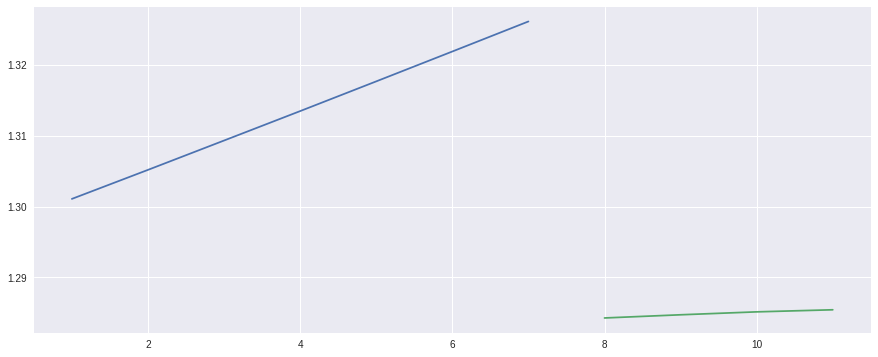

In [640]:
# the reason or 127 is that you are taking 134-7
plt.plot(day_new, scaler.inverse_transform(normalisation_us_deaths[127:]))
# print the predicted next 4 days 
plt.plot(day_pred, scaler.inverse_transform(lst_output))

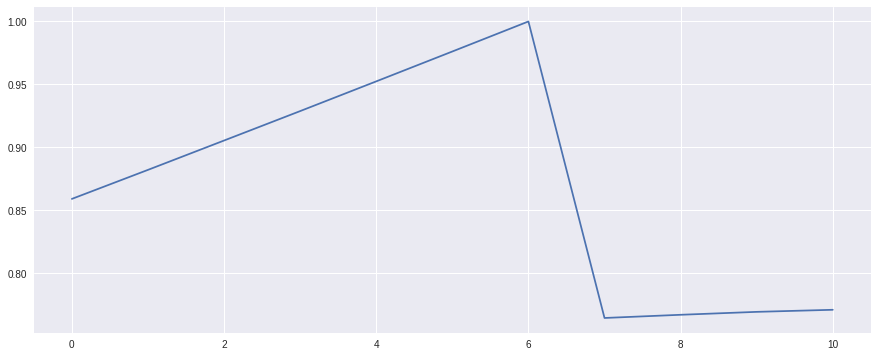

In [644]:
# Combine actual and prediction
df3=normalisation_us_deaths.tolist()
df3.extend(lst_output)
plt.plot(df3[127:])